# Analyzing Negative Temperature Intervals

In this notebook, we seek to:
1. Identify the duration that the internal temp. of the compressor is below 0°C.
2. Determine the frequency that the internal temp. measures below 0°C.
3. Explore causes for the gap in actual and requested temp. and why the internal temp. measures below 0°C.

### Data Loading

In [281]:
import pandas as pd

In [352]:
pivotted_f = pd.read_csv(r'C:\Users\achopra8\Documents\BDD Climate Control\2019f150VIN1FTEW1C53KFB01079_pivotted_tripflags_imputed_new.csv')
pivotted_f['cvdcus_timestamp_s_3'] = pd.to_datetime(pivotted_f['cvdcus_timestamp_s_3'])
pivotted_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68903 entries, 0 to 68902
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   cvdcus_timestamp_s_3   68903 non-null  datetime64[ns]
 1   epoch                  68903 non-null  float64       
 2   epoch_diff             68902 non-null  float64       
 3   trip                   68903 non-null  int64         
 4   BrkTot_Tq_Actl         68903 non-null  float64       
 5   Veh_V_ActlEng          68903 non-null  float64       
 6   ApedPos_Pc_ActlArb     68903 non-null  float64       
 7   EngAout_N_Actl         68903 non-null  float64       
 8   HvacEvap_Te_Actl       68903 non-null  float64       
 9   HvacEvap_Te_Rq         68903 non-null  float64       
 10  BattULo_U_Actl         68903 non-null  float64       
 11  AirCondFluidHi_P_Actl  68903 non-null  float64       
 12  AirAmb_Te_ActlFilt     68903 non-null  float64       
 13  O

Now let's map actual temperature values to signs (negative = -1, positive = 1, zero = 0). This will allow us to extract all negative temperature intervals.

In [353]:
import numpy as np

def map_temp_to_sign_get_intervals(pivotted, upper_bound_temp):
    pivotted['HvacEvap_Te_Actl_sign'] = pivotted_f['HvacEvap_Te_Actl'].map(lambda x: -1 if 0 <= x <= upper_bound_temp else np.sign(x)) # col to keep track of sign

    neg_temp_intervals = []
    for trip in pivotted['trip'].unique():
        temp = pivotted[pivotted['trip'] == trip]
        for i, g in temp.groupby([(pivotted['HvacEvap_Te_Actl_sign'] != pivotted['HvacEvap_Te_Actl_sign'].shift()).cumsum()]):
            if g.loc[g.index[0], 'HvacEvap_Te_Actl_sign'] == -1:
                neg_temp_intervals.append(g)
    #neg_temp_intervals.sort(key=lambda x: x['epoch'].max() - x['epoch'].min())
    return neg_temp_intervals

neg_temp_intervals_imputed = map_temp_to_sign_get_intervals(pivotted_f, 0)

### Descriptive Statistics

In [286]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import describe

DescribeResult(nobs=40, minmax=(0.0, 28.0), mean=4.2, variance=20.984615384615388, skewness=3.6135045328847575, kurtosis=16.43867585131421)


Text(0, 0.5, 'Density')

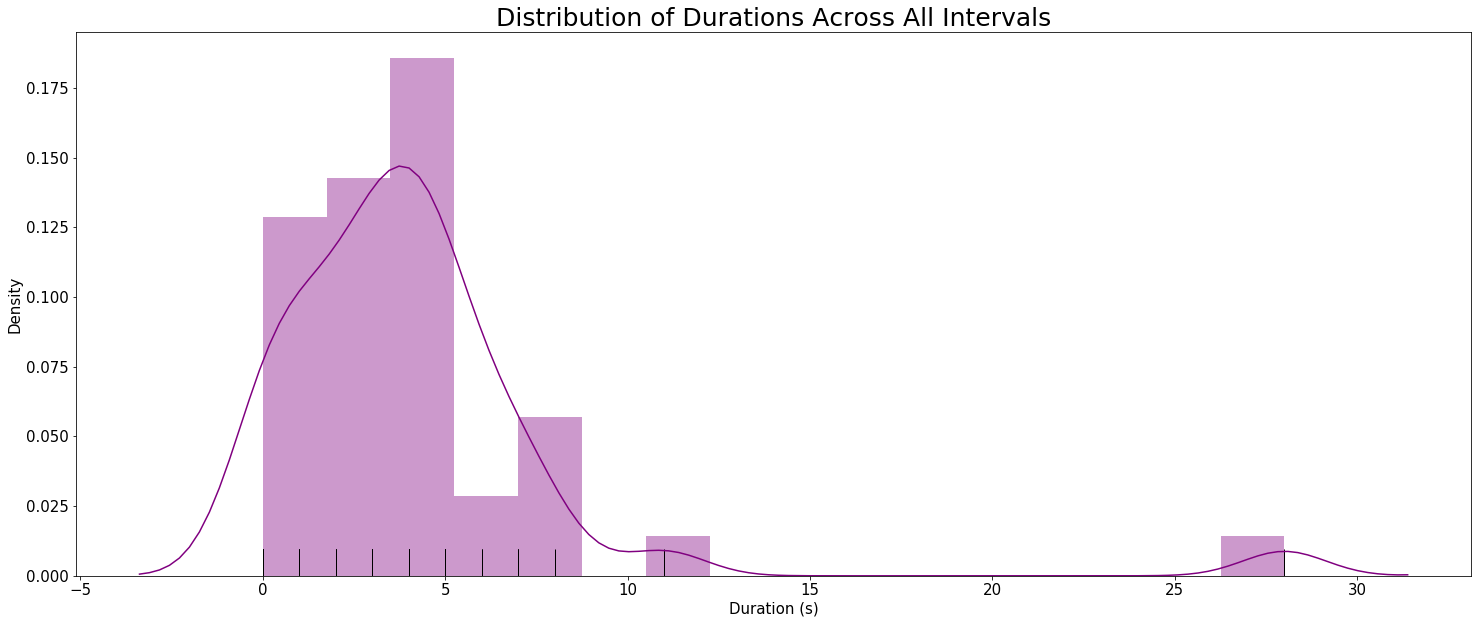

In [355]:
time_elap_imputed = [interval['epoch'].max() - interval['epoch'].min() for interval in neg_temp_intervals_imputed]
print(describe(time_elap_imputed))
fig, ax = plt.subplots(figsize=(25, 10))
sns.distplot(time_elap_imputed, color='Purple', rug=True, rug_kws={"color": "black"})
plt.title('Distribution of Durations Across All Intervals', fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel('Duration (s)', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Density', fontsize=15)

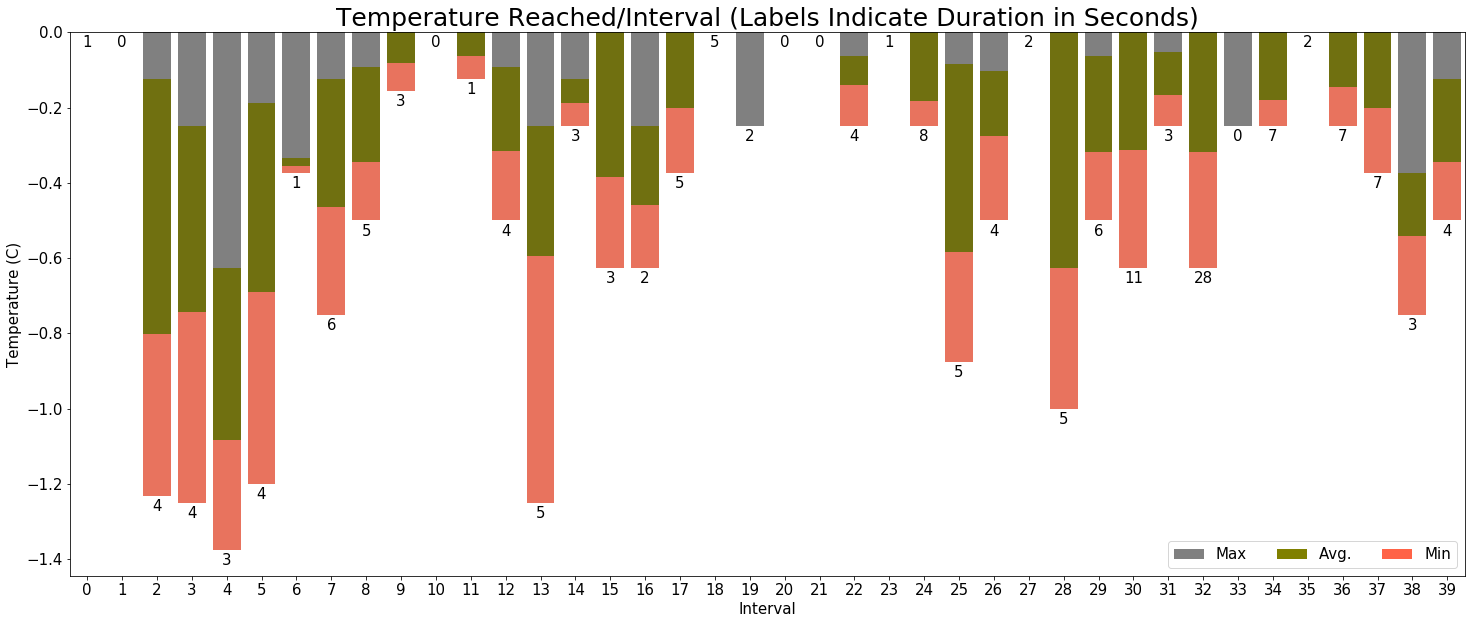

In [356]:
# function to make color gradient based on values
# def colors_from_values(values, palette_name):
#     # normalize the values to range [0, 1]
#     normalized = (values - min(values)) / (max(values) - min(values))
#     # convert to indices
#     indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
#     # use the indices to get the colors
#     palette = sns.color_palette(palette_name, len(values))
#     return np.array(palette).take(indices, axis=0)

fig, ax = plt.subplots(figsize=(25, 10))
min_temps = [interval['HvacEvap_Te_Actl'].min() for interval in neg_temp_intervals_imputed]
avg_temps = [interval['HvacEvap_Te_Actl'].mean() for interval in neg_temp_intervals_imputed]
max_temps = [interval['HvacEvap_Te_Actl'].max() for interval in neg_temp_intervals_imputed]
sns.barplot(x=[str(i) for i in range(len(neg_temp_intervals_imputed))], y=min_temps, order=[str(i) for i in range(len(neg_temp_intervals_imputed))], color='tomato')
sns.barplot(x=[str(i) for i in range(len(neg_temp_intervals_imputed))], y=avg_temps, order=[str(i) for i in range(len(neg_temp_intervals_imputed))], color='olive')
g = sns.barplot(x=[str(i) for i in range(len(neg_temp_intervals_imputed))], y=max_temps, order=[str(i) for i in range(len(neg_temp_intervals_imputed))], color='grey')
plt.title('Temperature Reached/Interval (Labels Indicate Duration in Seconds)', fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel('Interval', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Temperature (C)', fontsize=15)
leg_colors = [plt.Rectangle((0,0),1,1,fc='grey'), plt.Rectangle((0,0),1,1,fc='olive'), plt.Rectangle((0,0),1,1,fc="tomato")]
plt.legend(leg_colors, ['Max', 'Avg.', 'Min'], ncol = 3, prop={'size':15})

for interval, temp, duration in zip(range(len(neg_temp_intervals_imputed)), min_temps, time_elap_imputed):
    g.text(interval, temp - 0.04, round(duration), color='black', ha="center", fontsize=15)

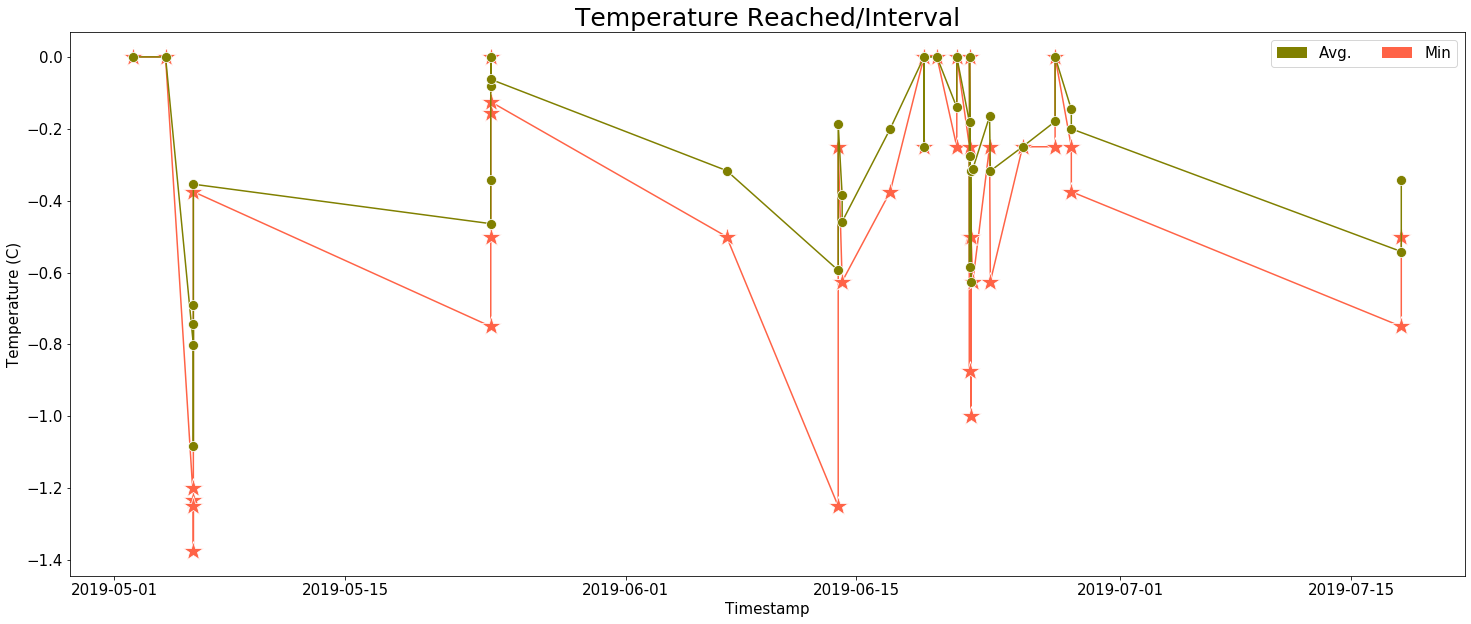

In [366]:
fig, ax = plt.subplots(figsize=(25, 10))
min_temps = [interval['HvacEvap_Te_Actl'].min() for interval in neg_temp_intervals_imputed]
avg_temps = [interval['HvacEvap_Te_Actl'].mean() for interval in neg_temp_intervals_imputed]
max_temps = [interval['HvacEvap_Te_Actl'].max() for interval in neg_temp_intervals_imputed]
sns.lineplot(x=[interval['cvdcus_timestamp_s_3'].min() for interval in neg_temp_intervals_imputed], y=min_temps, color='tomato', marker='*', markersize=20)
sns.lineplot(x=[interval['cvdcus_timestamp_s_3'].min() for interval in neg_temp_intervals_imputed], y=avg_temps, color='olive', marker='o', markersize=10)
#sns.lineplot(x=[interval['cvdcus_timestamp_s_3'].min() for interval in neg_temp_intervals_imputed], y=max_temps, color='grey', marker='s', markersize=10)

plt.title('Temperature Reached/Interval', fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel('Timestamp', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Temperature (C)', fontsize=15)
leg_colors = [plt.Rectangle((0,0),1,1,fc='olive'), plt.Rectangle((0,0),1,1,fc="tomato")]
plt.legend(leg_colors, ['Avg.', 'Min'], ncol = 2, prop={'size':15})

Text(0, 0.5, 'Temperature (C)')

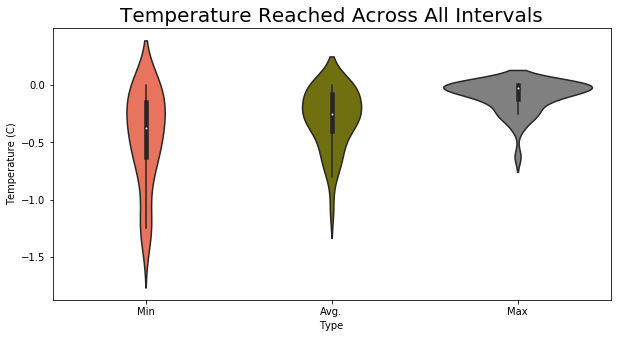

In [358]:
fig, ax = plt.subplots(figsize=(10, 5))
pal = {'Min':'tomato', 'Avg.':'olive', 'Max':'grey'}
sns.violinplot(x='variable', y='value', data=pd.melt(pd.DataFrame({'Min':min_temps, 'Avg.':avg_temps, 'Max':max_temps})), palette=pal)
plt.title('Temperature Reached Across All Intervals', fontsize=20)
plt.xticks(fontsize=10)
plt.xlabel('Type', fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Temperature (C)', fontsize=10)



DescribeResult(nobs=40, minmax=(8.0, 1728918.0), mean=167250.6, variance=164256946223.01538, skewness=2.9947440564140537, kurtosis=7.762496101477852)


Text(0, 0.5, 'Density')

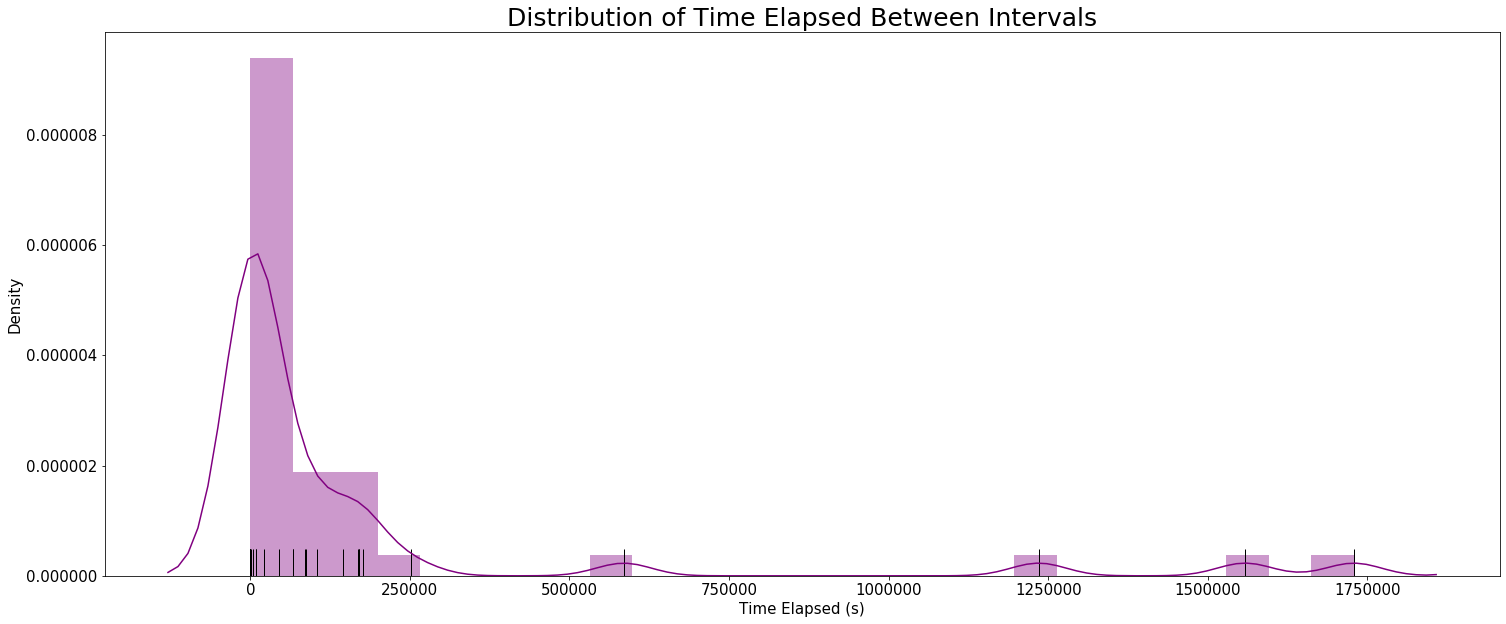

In [359]:
time_elap_between_intervals = np.diff(sorted([pivotted_f['epoch'].min()] + [interval['epoch'].iloc[0] for interval in neg_temp_intervals_imputed]))
print(describe(time_elap_between_intervals))
fig, ax = plt.subplots(figsize=(25, 10))
sns.distplot(time_elap_between_intervals, color='Purple', rug=True, rug_kws={"color": "black"})
plt.title('Distribution of Time Elapsed Between Intervals', fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel('Time Elapsed (s)', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Density', fontsize=15)

In [360]:
print(pivotted_f['cvdcus_timestamp_s_3'].min())
print(pivotted_f['cvdcus_timestamp_s_3'].max())

2019-05-01 14:40:10
2019-07-18 04:14:46


Over the span of summer 2019 (May - July), the actual temperature is below 0°C every 161296 seconds (1.8 days) on average.

Let's look closer at how the other signals are changing during these intervals. Interval 57 looks particularily concerning, as it lasts the longest (31 seconds) and reaches a minimum temperature of -0.6.

In [361]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def show_interval(interval=range(len(neg_temp_intervals_imputed))):
    display(neg_temp_intervals_imputed[interval])

interactive(children=(Dropdown(description='interval', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, …

In [362]:
@interact
def generate_heatmap(save_fig=widgets.Checkbox(value=False, description='Save Plot'), interval=range(len(neg_temp_intervals_imputed))):
    interval = neg_temp_intervals_imputed[interval]
    f, ax = plt.subplots(figsize=(14, 12)) 
    try:
        heatmap = sns.heatmap(pd.get_dummies(interval[['epoch'] + list(interval.columns[4:-1])]).corr(), annot=True, linewidths=0.5)
    except ValueError:
        print('Cannot produce heatmap since interval only lasts for 1 second!')
        plt.close()
    else:
        if save_fig:
            try:
                f.savefig('neg_temp_intervals/heatmaps/Trip{}.png'.format(interval['trip'].iloc[0]))
            except FileNotFoundError:
                print("Directory doesn't exists! Make directory called 'neg_temp_intervals/heatmaps'")
        return heatmap

interactive(children=(Checkbox(value=False, description='Save Plot'), Dropdown(description='interval', options…

In [363]:
from matplotlib.lines import Line2D
import matplotlib as mpl
# function to plot gap between actual and requested temp.
def plot_vs_time(df, trip_num, feature, xlab='Time Elapsed (s)'):
    plt.close('all')
    if pivotted_f[feature].dtype == 'O':
        df['epoch'] = (df['epoch'] - df['epoch'].min()).astype(int)
        fig, ax = plt.subplots(figsize=(38, 15))
        plt.title(f'Actual Temperature vs. Time (Trip {trip_num})', fontsize=30)
        sns.lineplot(x='epoch', y='HvacEvap_Te_Actl', hue=feature, data=df, marker='o', markersize=10)
        plt.xlabel(xlab, fontsize=20)
        plt.xticks(fontsize=20)
        plt.ylabel('Actual (C)', fontsize=20)
        plt.yticks(fontsize=20)
        plt.legend(prop={'size': 20})
       
        return fig
    
    else:
        fig, ax1 = plt.subplots(figsize=(38, 15))
        plt.title(f'Features vs. Time (Trip {trip_num})', fontsize=30)
        plt.xticks(fontsize=20)
        ax2 = ax1.twinx()
        df['epoch'] = (df['epoch'] - df['epoch'].min()).astype(int)
        sns.lineplot(x="epoch", y="HvacEvap_Te_Actl", data=df, ax=ax1, marker='o', markersize=10, legend=False) 
        sns.lineplot(x='epoch', y=feature, data=df, ax=ax2, marker='o', markersize=10, color='purple')
        ax1.set_ylabel('Actual (C)', fontsize=20)
        ax1.tick_params(axis='y', which='major', labelsize=20)
        ax2.set_ylabel(feature, fontsize=20)
        ax2.tick_params(axis='y', which='major', labelsize=20)
        ax1.set_xlabel(xlab, fontsize=20)
        custom_lines = [Line2D([0], [0], lw=4, color='Blue'), Line2D([0], [0], lw=4, color='Purple')]
        plt.legend(custom_lines, ['Actual', f'{feature}'], prop={'size': 20})
        return fig

In [381]:
@interact
def show_rel(save_fig=widgets.Checkbox(value=False, description='Save Plot'), interval_num=range(len(neg_temp_intervals_imputed)), feature=[col for col in pivotted_f.columns[4:] if col not in ['HvacEvap_Te_Actl', 'HvacEvap_Te_Rq', 'temp_gap', 'HvacAirCond_B_Rq', 'HvacEvap_Te_Actl_sign']]):
    interval = neg_temp_intervals_imputed[interval_num]
    trip_num = interval['trip'].iloc[0]
    interval = interval[['epoch'] + list(interval.columns[4:])]
    try:
        fig = plot_vs_time(interval, trip_num, feature)
        if save_fig:
            try:
                fig.savefig(f'neg_temp_intervals/time_series_plots/Trip{trip_num}_{feature}.png')
            except FileNotFoundError:
                print("Directory doesn't exists! Make directory called 'neg_temp_intervals/time_series_plots'")
    except ValueError:
        print('Feature not present in trip!')
        plt.close()

interactive(children=(Checkbox(value=False, description='Save Plot'), Dropdown(description='interval_num', opt…

Negative temperatures appear more concerning when the gap between actual and requested temperature is small

In [380]:
@interact
def compare(max_temp=(-1.37, 0, 0.1)):
    gap_stats = pivotted_f[pivotted_f['HvacEvap_Te_Actl'] < max_temp][pivotted_f.columns[4:]].drop(['OdometerMasterValue', 'HvacAirCond_B_Rq'], axis=1).describe(include='all')
    overall_stats = pivotted_f[pivotted_f.columns[4:]].drop(['OdometerMasterValue', 'HvacAirCond_B_Rq'], axis=1).describe(include='all')

    stats_comparison = pd.concat([gap_stats, overall_stats]).loc[['count', 'mean', 'top']]
    stats_comparison = stats_comparison.iloc[[0] + list(range(2,6))]
    stats_comparison.index = ['# Timestamps', 'Avg. for Times w/ Actual < Threshold ', 'Global Avg.', 'Mode for Times w/ Actual < Threshold', 'Global Mode']
    display(stats_comparison.transpose())

interactive(children=(FloatSlider(value=-0.77, description='max_temp', max=0.0, min=-1.37), Output()), _dom_cl…

In [405]:
time_elap_between_intervals[time_elap_between_intervals < 10]

array([8., 8.])

In [402]:
time_elap_between_intervals

array([4.501700e+04, 1.699520e+05, 1.456890e+05, 1.100000e+01,
       1.100000e+01, 1.000000e+01, 1.100000e+01, 1.558336e+06,
       1.000000e+01, 1.300000e+01, 1.500000e+01, 4.240000e+02,
       1.235035e+06, 5.850420e+05, 1.100000e+01, 2.069900e+04,
       1.200000e+01, 2.516920e+05, 1.771930e+05, 2.700000e+01,
       6.100000e+01, 6.744700e+04, 1.042200e+05, 3.200000e+01,
       6.659100e+04, 1.600000e+01, 1.100000e+01, 1.900000e+01,
       8.107000e+03, 8.000000e+00, 9.180000e+03, 8.774900e+04,
       4.176000e+03, 1.689400e+05, 1.702380e+05, 2.400000e+01,
       8.504500e+04, 2.400000e+01, 1.728918e+06, 8.000000e+00])